### Project Title: 
## Prediction of molecular properties using graphs

### Team Members

* PES1UG20CS192 - KANUMARI SRI CHARAN (Section D)
* PES1UG20CS331 - RENITA KURIAN (Section F)
* PES1UG20CS344 - RIYA JHA (Section F)
* PES1UG20CS484 - VANSHIKA GOEL (Section H)

#### Version Details
*   DeepChem: 2.7.2.dev
*   TensorFlow: 2.12.0



## Installing Deepchem and Loading Dataset

In [1]:
# Installing Deepchem
!pip install --pre deepchem
# Import deepchem just to check the version
import deepchem
#deepchem.__version__


[notice] A new release of pip is available: 23.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


# Importing required libraries and its utilities


In [2]:
import numpy as np

np.random.seed(123)
import tensorflow as tf

tf.random.set_seed(123)
import deepchem as dc
from deepchem.molnet import load_tox21
from deepchem.models.graph_models import GraphConvModel
from deepchem.data import NumpyDataset
from rdkit import Chem
from deepchem.molnet import load_tox21

# tf.__version__
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import tempfile
from sklearn.svm import SVC

### Load Tox21 dataset


In [4]:
n_features = 1024
tox21_tasks, tox21_datasets, transformers = dc.molnet.load_tox21()
train_dataset, valid_dataset, test_dataset = tox21_datasets

### Description of Dataset
The Tox21 dataset consists of 12 binary classification tasks that assess the activity of compounds against specific biological targets. Here's an overview of each task:

NR-AR (Nuclear Receptor Androgen Receptor): Measures the activity of compounds on the androgen receptor.

NR-AR-LBD (Nuclear Receptor Androgen Receptor Ligand Binding Domain): Assesses the ligand binding activity of compounds to the ligand binding domain of the androgen receptor.

NR-AhR (Nuclear Receptor Aryl Hydrocarbon Receptor): Evaluates the activity of compounds on the aryl hydrocarbon receptor.

NR-Aromatase (Nuclear Receptor Aromatase): Measures the inhibitory activity of compounds on the aromatase enzyme.

NR-ER (Nuclear Receptor Estrogen Receptor): Assesses the activity of compounds on the estrogen receptor.

NR-ER-LBD (Nuclear Receptor Estrogen Receptor Ligand Binding Domain): Measures the ligand binding activity of compounds to the ligand binding domain of the estrogen receptor.

NR-PPAR-gamma (Nuclear Receptor Peroxisome Proliferator-Activated Receptor Gamma): Evaluates the activity of compounds on the peroxisome proliferator-activated receptor gamma.

SR-ARE (Stress Response Antioxidant Response Element): Assesses the activation of the antioxidant response element pathway by compounds.

SR-ATAD5 (Stress Response Ataxia Telangiectasia Mutated Serine/Threonine Kinase Substrate): Measures the genotoxicity of compounds by evaluating their interaction with the Ataxia Telangiectasia Mutated kinase substrate.

SR-HSE (Stress Response Heat Shock Response Element): Evaluates the activation of the heat shock response element pathway by compounds.

SR-MMP (Stress Response Matrix Metalloproteinase): Assesses the inhibitory activity of compounds on matrix metalloproteinases.

SR-p53 (Stress Response p53 Pathway): Measures the activation of the p53 pathway by compounds.

## Visualizing Compounds from the Database


[notice] A new release of pip is available: 23.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


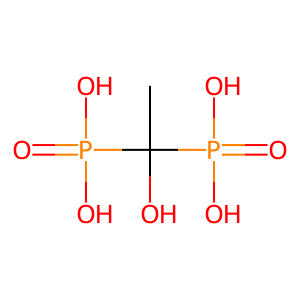

In [5]:
!pip install rdkit
from rdkit.Chem import Draw
# Select a molecule from the dataset
molecule_smiles = train_dataset.ids[0]

# Convert the SMILES string to an RDKit molecule object
molecule = Chem.MolFromSmiles(molecule_smiles)

# Render the molecule in a Jupyter notebook cell
img = Draw.MolToImage(molecule, size=(300, 300))
img

#SVM Model

### Training SVM Model

In [6]:
# Define metric for the model
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)

In [7]:
def model_builder(model_dir):
  sklearn_model = SVC(C=1.0, class_weight="balanced", probability=True)
  return dc.models.SklearnModel(sklearn_model, model_dir)

In [8]:
model = dc.models.SingletaskToMultitask(tox21_tasks, model_builder)
model.fit(train_dataset)

### Evaluating the Model

In [9]:
train_scores = model.evaluate(train_dataset, [metric], transformers)
valid_scores = model.evaluate(valid_dataset, [metric], transformers)

print("Train scores\t", train_scores['roc_auc_score'])
print("Validation scores\t", valid_scores['roc_auc_score'])

Train scores	 0.996216850531365
Validation scores	 0.74177858003122


## Predicting Properties of a given molecule

In [10]:
compound_index = 10

compound = tox21_datasets[0].X[compound_index]
compound_batch = np.expand_dims(compound, axis=0)
predictions = model.predict_on_batch(compound_batch)
compound_predictions = predictions[0]

In [11]:
for task_name, predicted_value in zip(tox21_tasks, compound_predictions):
    print(f"{task_name}: {predicted_value}")

NR-AR: [0.98931473 0.01068527]
NR-AR-LBD: [0.99402269 0.00597731]
NR-AhR: [0.9848092 0.0151908]
NR-Aromatase: [0.99544872 0.00455128]
NR-ER: [0.80830342 0.19169658]
NR-ER-LBD: [0.99307563 0.00692437]
NR-PPAR-gamma: [0.9924484 0.0075516]
SR-ARE: [0.98834183 0.01165817]
SR-ATAD5: [0.99617958 0.00382042]
SR-HSE: [0.98535919 0.01464081]
SR-MMP: [0.98239739 0.01760261]
SR-p53: [0.99568622 0.00431378]


In [12]:
# Print out properties that molecule tested positive for
# ie. properties where prediction above threshold

taskval = 0
threshold = 0.1

for val in compound_predictions:
  if(val[1]>threshold):
    print(tox21_tasks[taskval])
  taskval = taskval + 1

NR-ER


In the context of the 'NR-AR' task, a predicted value of 1 indicates that the compound is predicted to be active in binding to the androgen receptor. This means that the compound has a higher likelihood of interacting with the receptor and potentially affecting the related biological pathway. However, whether this activity is considered toxic or not depends on the specific application, desired effects, and the potential consequences of modulating the androgen receptor pathway.



### Graph based Models - GCN, GAT and GGCN

In [13]:
# Tox21 is a part of Deepchem library
# so we can convieniently download it using load_tox21 function
tox21_tasks, tox21_datasets, transformers = load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = tox21_datasets

#### GCN Model



In [14]:
# Define and fit the model
GCN_model = GraphConvModel(len(tox21_tasks), 
                       batch_size=32,
                       activation_fn=tf.nn.relu,
                       mode='classification')
print("Fitting the model")
GCN_model.fit(train_dataset, nb_epoch=10)

Fitting the model


0.663873036702474

In [15]:
print("Evaluating model with ROC AUC")
train_scores = GCN_model.evaluate(train_dataset, [metric], transformers)
valid_scores = GCN_model.evaluate(valid_dataset, [metric], transformers)

Evaluating model with ROC AUC


In [16]:
print("Train scores")
print(train_scores)

print("Validation scores")
print(valid_scores)

Train scores
{'roc_auc_score': 0.9011293673670222}
Validation scores
{'roc_auc_score': 0.7242865308604531}


#### GAT Model

In [17]:
GAT_model = GraphConvModel(len(tox21_tasks), 
                 batch_size=32, 
                 mode='classification',
                 dropout=0.2,
                 activation_fn=tf.nn.relu,
                 model_dir = 'gat_model')
print("Fitting the model")
GAT_model.fit(train_dataset, nb_epoch=10)

Fitting the model


0.8234849294026693

In [18]:
print("Evaluating model with ROC AUC")
train_scores = GAT_model.evaluate(train_dataset, [metric], transformers)
valid_scores = GAT_model.evaluate(valid_dataset, [metric], transformers)

Evaluating model with ROC AUC


In [19]:
print("Train scores")
print(train_scores)

print("Validation scores")
print(valid_scores)

Train scores
{'roc_auc_score': 0.8501553670999931}
Validation scores
{'roc_auc_score': 0.7264629184591654}


#### Gated GCN Model

In [20]:
# from deepchem.models import GatedGraphConvModel

GGCN_model = GraphConvModel(
    len(tox21_tasks),
    batch_size=32,
    mode = "classification",
    dropout = 0.2,
    activation_fn=tf.nn.relu,
    model_dir='ggcn_model'
)
print("Fitting the model")
GGCN_model.fit(train_dataset, nb_epoch=10)

Fitting the model


0.8479443232218424

In [21]:
print("Evaluating model with ROC AUC")
train_scores = GGCN_model.evaluate(train_dataset, [metric], transformers)
valid_scores = GGCN_model.evaluate(valid_dataset, [metric], transformers)

Evaluating model with ROC AUC


In [22]:
print("Train scores")
print(train_scores)

print("Validation scores")
print(valid_scores)

Train scores
{'roc_auc_score': 0.8488871049924797}
Validation scores
{'roc_auc_score': 0.7257281206663931}


## Predictions for the Graph Network models

In [23]:
compound_index = 10
compound = tox21_datasets[0].X[compound_index]
compound_batch = np.expand_dims(compound, axis=0)

Firstly the GCN model

In [24]:
predictions = GCN_model.predict_on_batch(compound_batch)
compound_predictions = predictions[0]

In [25]:
for task_name, predicted_value in zip(tox21_tasks, compound_predictions):
    print(f"{task_name}: {predicted_value}")

NR-AR: [0.8350107  0.16498922]
NR-AR-LBD: [0.98013544 0.01986449]
NR-AhR: [0.86435246 0.13564757]
NR-Aromatase: [9.993962e-01 6.037502e-04]
NR-ER: [0.74250513 0.25749478]
NR-ER-LBD: [0.9866917 0.0133083]
NR-PPAR-gamma: [0.9958293  0.00417077]
SR-ARE: [0.9910584 0.0089416]
SR-ATAD5: [0.9967464  0.00325352]
SR-HSE: [0.9597537  0.04024627]
SR-MMP: [0.9938478  0.00615223]
SR-p53: [0.9980501  0.00194993]


In [26]:
taskval = 0
threshold = 0.1

for val in compound_predictions:
  if(val[1]>threshold):
    print(tox21_tasks[taskval])
  taskval = taskval + 1

NR-AR
NR-AhR
NR-ER


GAT model predictions

In [27]:
predictions = GAT_model.predict_on_batch(compound_batch)
compound_predictions = predictions[0]

In [28]:
for task_name, predicted_value in zip(tox21_tasks, compound_predictions):
    print(f"{task_name}: {predicted_value}")

NR-AR: [0.85933304 0.14066692]
NR-AR-LBD: [0.88434523 0.11565472]
NR-AhR: [0.98227894 0.01772106]
NR-Aromatase: [0.99442273 0.00557727]
NR-ER: [0.80338514 0.19661486]
NR-ER-LBD: [0.944622   0.05537799]
NR-PPAR-gamma: [0.9754372  0.02456272]
SR-ARE: [0.91628736 0.08371266]
SR-ATAD5: [0.96432334 0.03567671]
SR-HSE: [0.9122614 0.0877386]
SR-MMP: [0.9890471  0.01095286]
SR-p53: [0.9857253  0.01427473]


In [29]:
taskval = 0
threshold = 0.1

for val in compound_predictions:
  if(val[1]>threshold):
    print(tox21_tasks[taskval])
  taskval = taskval + 1

NR-AR
NR-AR-LBD
NR-ER


Lastly, the GGCN Model predictions

In [30]:
predictions = GGCN_model.predict_on_batch(compound_batch)
compound_predictions = predictions[0]

In [31]:
for task_name, predicted_value in zip(tox21_tasks, compound_predictions):
    print(f"{task_name}: {predicted_value}")

NR-AR: [0.7700172  0.22998281]
NR-AR-LBD: [0.98123986 0.01876008]
NR-AhR: [0.98258483 0.01741508]
NR-Aromatase: [0.99762684 0.00237312]
NR-ER: [0.8686609  0.13133907]
NR-ER-LBD: [0.9619081  0.03809191]
NR-PPAR-gamma: [0.96219176 0.03780825]
SR-ARE: [0.982682   0.01731796]
SR-ATAD5: [0.9919918  0.00800817]
SR-HSE: [0.9809483  0.01905166]
SR-MMP: [0.9974376 0.0025624]
SR-p53: [0.99341875 0.00658117]


In [32]:
taskval = 0
threshold = 0.1

for val in compound_predictions:
  if(val[1]>threshold):
    print(tox21_tasks[taskval])
  taskval = taskval + 1

NR-AR
NR-ER


As you can see, the GCN model predicts that the compound is active in binding to the androgen receptor. This is the same prediction that the SVM model made, with additional features going over the threshold such as the NR-AR and NR-AhR. The GAT model predicted that the NR-AR-LBD was over the threshold instead of the NR-AhR. The GGCN model predicted just the NR-AR and NR-ER to be over the threshold. 